# Retail Sales Forecasting Using Time Series Models

**Problem Statement:** Accurate demand forecasting is a critical challenge in the retail sector.
Poor forecasts can lead to overstocking, stockouts, and disrupted cash flows. This project aims
to forecast daily sales for a variety of product families across multiple Favorita stores in
Ecuador. By leveraging time series modeling techniques, we aim to support more efficient
inventory planning and resource allocation.


**Data Source:** The dataset is sourced from the Kaggle competition “Store Sales – Time Series
Forecasting,” which contains over four years of sales data.
Link: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

Key files include:

- train.csv: Daily sales data by store and product fam\
- stores.csv: Metadata about each store, including location, type, and cluster.
- oil.csv: Daily oil prices, which reflect Ecuador’s economic climate.
- holidays_events.csv: National and regional holidays, including transferred and
bridge days.
- test.csv: The evaluation set, covering 15 days after the training period.

This dataset is well-suited for building and validating real-world retail demand forecasting
models.

**Methodology:** The project will be implemented on Databricks to efficiently handle time series
data and enable scalable model deployment. The approach includes:
- Data preprocessing and feature engineering, incorporating temporal trends,
promotion effects, holiday indicators, and economic signals such as oil prices.
- Development of time series models such as Prophet and SARIMAX, with both
univariate and multivariate configurations.
- Model tuning and hyperparameter optimization to improve accuracy and
generalizability.

To enhance interpretability and usability, a Streamlit dashboard will be developed to visualize
forecasts by product and location, display confidence intervals, and allow users to interactively
explore prediction results.

**Business Value:**
- Inventory Optimization: Reduce overstock and out-of-stock events by aligning supply
with forecasted demand.
- Operational Efficiency: Enable data-driven replenishment planning at store level.
- Strategic Planning: Provide insights into the impact of external events (e.g.,
promotions, holidays, economic fluctuations) on demand patterns.

#Import Dataset

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

path = '/content/drive/MyDrive/MSBA/Analytics Practicum/Dataset/'
holidays = pd.read_csv(path + 'holidays_events.csv')
oil_price = pd.read_csv(path + 'oil.csv')
stores = pd.read_csv(path + 'stores.csv')
transactions = pd.read_csv(path + 'transactions.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

#Data Cleaning


## Holidays


In [ ]:
holidays.info()
holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


 A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [ ]:
#correcting all the datatypes
holidays['date'] = pd.to_datetime(holidays['date'])

In [ ]:
#one-hot encode columns
#holidays = pd.get_dummies(holidays, columns=['type'])
#holidays = pd.get_dummies(holidays, columns=['locale'])

In [ ]:
holidays.loc[holidays['locale'] == 'Local', 'locale'] = 1
holidays.loc[holidays['locale'] == 'Regional', 'locale'] = 2
holidays.loc[holidays['locale'] == 'National', 'locale'] = 3

In [ ]:
#identify all days that are holidays because of some cultural event
holidays['holiday'] = False
holidays.loc[holidays['type'] == 'Holiday', 'holiday'] = True

#identify work days
holidays['workday'] = True
#extract day from date and put monday to friday as workdays
holidays['day'] = holidays['date'].dt.day_name()
holidays.loc[holidays['day'].isin(['Saturday', 'Sunday']), 'workday'] = False

holidays.loc[holidays['type'] == 'Work Day', 'workday'] = True
holidays.loc[holidays['type'] == 'Bridge', 'workday'] = False
holidays.loc[holidays['type'] == 'Transfer', 'workday'] = False
holidays.loc[(holidays['type'] == 'Holiday') & (holidays['transferred'] == False), 'workday'] = False

In [ ]:
holidays.description.unique()
holidays.drop(columns=['description', 'locale_name', 'transferred', 'type', 'day'], inplace=True)

In [ ]:
holidays.info()
holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     350 non-null    datetime64[ns]
 1   locale   350 non-null    object        
 2   holiday  350 non-null    bool          
 3   workday  350 non-null    bool          
dtypes: bool(2), datetime64[ns](1), object(1)
memory usage: 6.3+ KB


,date,locale,holiday,workday
0,2012-03-02,1,True,False
1,2012-04-01,2,True,False
2,2012-04-12,1,True,False
3,2012-04-14,1,True,False
4,2012-04-21,1,True,False


## Oil Prices

In [ ]:
oil_price.info()
oil_price.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
#fix datatypes
oil_price['date'] = pd.to_datetime(oil_price['date'])

In [ ]:
#impute values
oil_price['dcoilwtico'] = oil_price['dcoilwtico'].interpolate(method='spline', order=2)

In [ ]:
oil_price.info()
oil_price.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1217 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


## Stores

In [ ]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
stores.drop(columns=['type', 'cluster'], inplace=True)

In [ ]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


,store_nbr,city,state
0,1,Quito,Pichincha
1,2,Quito,Pichincha
2,3,Quito,Pichincha
3,4,Quito,Pichincha
4,5,Santo Domingo,Santo Domingo de los Tsachilas


## Transactions

In [ ]:
transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
#correct data type
transactions['date'] = pd.to_datetime(transactions['date'])

transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Train

In [ ]:
train.info(show_counts=True)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           3000888 non-null  int64  
 1   date         3000888 non-null  object 
 2   store_nbr    3000888 non-null  int64  
 3   family       3000888 non-null  object 
 4   sales        3000888 non-null  float64
 5   onpromotion  3000888 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
#correct data types
train['date'] = pd.to_datetime(train['date'])

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
test.info(show_counts=True)
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Data Merge

In [ ]:
train_merge = train.merge(holidays, on='date', how='left')

In [ ]:
train_merge = train_merge.merge(oil_price, on='date', how='left')

In [ ]:
train_merge = train_merge.merge(stores, on='store_nbr', how='left')

In [ ]:
train_merge = train_merge.merge(transactions, on=['date', 'store_nbr'], how='left')

In [ ]:
train_merge.info(show_counts=True)
train_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3054348 non-null  int64         
 1   date          3054348 non-null  datetime64[ns]
 2   store_nbr     3054348 non-null  int64         
 3   family        3054348 non-null  object        
 4   sales         3054348 non-null  float64       
 5   onpromotion   3054348 non-null  int64         
 6   locale        502524 non-null   object        
 7   holiday       502524 non-null   object        
 8   workday       502524 non-null   object        
 9   dcoilwtico    2174040 non-null  float64       
 10  city          3054348 non-null  object        
 11  state         3054348 non-null  object        
 12  transactions  2805231 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 302.9+ MB


,id,date,store_nbr,family,sales,onpromotion,locale,holiday,workday,dcoilwtico,city,state,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,3,True,False,NaN,Quito,Pichincha,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,3,True,False,NaN,Quito,Pichincha,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,3,True,False,NaN,Quito,Pichincha,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,True,False,NaN,Quito,Pichincha,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,3,True,False,NaN,Quito,Pichincha,NaN


In [ ]:
train_merge['holiday'] = train_merge['holiday'].fillna(False)

/tmp/ipython-input-3578512757.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_merge['holiday'] = train_merge['holiday'].fillna(False)


In [ ]:
train_merge['day'] = train_merge['date'].dt.day_name()

if train_merge['workday'].isnull().any():
    train_merge['workday'] = np.where(train_merge['day'].isin(['Saturday', 'Sunday']), False, True)

train_merge.drop(columns=['day'], inplace=True)

In [ ]:
train_merge.info(show_counts=True)
train_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3054348 non-null  int64         
 1   date          3054348 non-null  datetime64[ns]
 2   store_nbr     3054348 non-null  int64         
 3   family        3054348 non-null  object        
 4   sales         3054348 non-null  float64       
 5   onpromotion   3054348 non-null  int64         
 6   locale        502524 non-null   object        
 7   holiday       3054348 non-null  bool          
 8   workday       3054348 non-null  bool          
 9   dcoilwtico    2174040 non-null  float64       
 10  city          3054348 non-null  object        
 11  state         3054348 non-null  object        
 12  transactions  2805231 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 262.2+ MB


,id,date,store_nbr,family,sales,onpromotion,locale,holiday,workday,dcoilwtico,city,state,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,3,True,True,NaN,Quito,Pichincha,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,3,True,True,NaN,Quito,Pichincha,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,3,True,True,NaN,Quito,Pichincha,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,3,True,True,NaN,Quito,Pichincha,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,3,True,True,NaN,Quito,Pichincha,NaN


In [ ]:
train_merge.to_csv('train_merge.parquet')

## Train - Test Split

In [ ]:
#split train_merge into train and test
train = train_merge[train_merge['date'] < '2017-08-01']
test = train_merge[train_merge['date'] >= '2017-08-01']

In [ ]:
#whats the train_merge date range?
print(train['date'].min())
print(train['date'].max())

print(test['date'].min())
print(test['date'].max())

2013-01-01 00:00:00
2017-07-31 00:00:00
2017-08-01 00:00:00
2017-08-15 00:00:00


In [ ]:
print(test)

              id       date  store_nbr                      family     sales  \
3027618  2974158 2017-08-01          1                  AUTOMOTIVE     5.000   
3027619  2974159 2017-08-01          1                   BABY CARE     0.000   
3027620  2974160 2017-08-01          1                      BEAUTY     4.000   
3027621  2974161 2017-08-01          1                   BEVERAGES  2627.000   
3027622  2974162 2017-08-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3054343  3000883 2017-08-15          9                     POULTRY   438.133   
3054344  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885 2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion locale  holiday  w

We will use store_nbr, family, city, state information to find trends

# EDA

In [ ]:
automotive_train = train[train['family'] == 'AUTOMOTIVE'].copy()
automotive_test = test[test['family'] == 'AUTOMOTIVE'].copy()

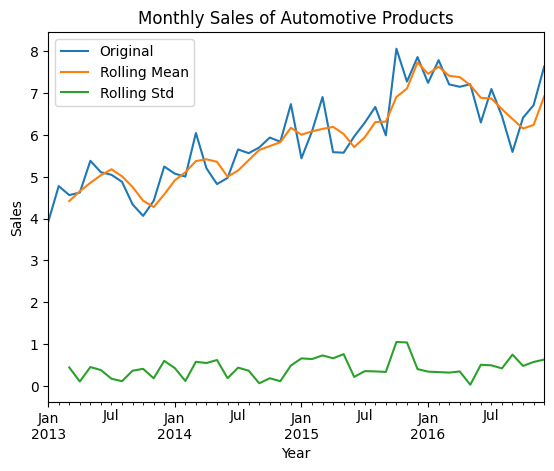

In [ ]:
#take monthly sales average
automotive_train['month'] = automotive_train['date'].dt.to_period('M')
automotive_monthly_sales = automotive_train.groupby('month')['sales'].mean().reset_index()

#Add rolling mean and rolling standard deviation
automotive_monthly_sales['rolling_mean'] = automotive_monthly_sales['sales'].rolling(window=3).mean()
automotive_monthly_sales['rolling_std'] = automotive_monthly_sales['sales'].rolling(window=3).std()
automotive_monthly_sales['month'] = automotive_monthly_sales['month'].dt.to_timestamp()

#plot original line, rolling mean and rolling std
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
automotive_monthly_sales.plot(x='month', y='sales', label='Original', ax=ax)
automotive_monthly_sales.plot(x='month', y='rolling_mean', label='Rolling Mean', ax=ax)
automotive_monthly_sales.plot(x='month', y='rolling_std', label='Rolling Std', ax=ax)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Monthly Sales of Automotive Products')
plt.legend()
plt.show()

Clearly there's an upward trend.

## Components of the series


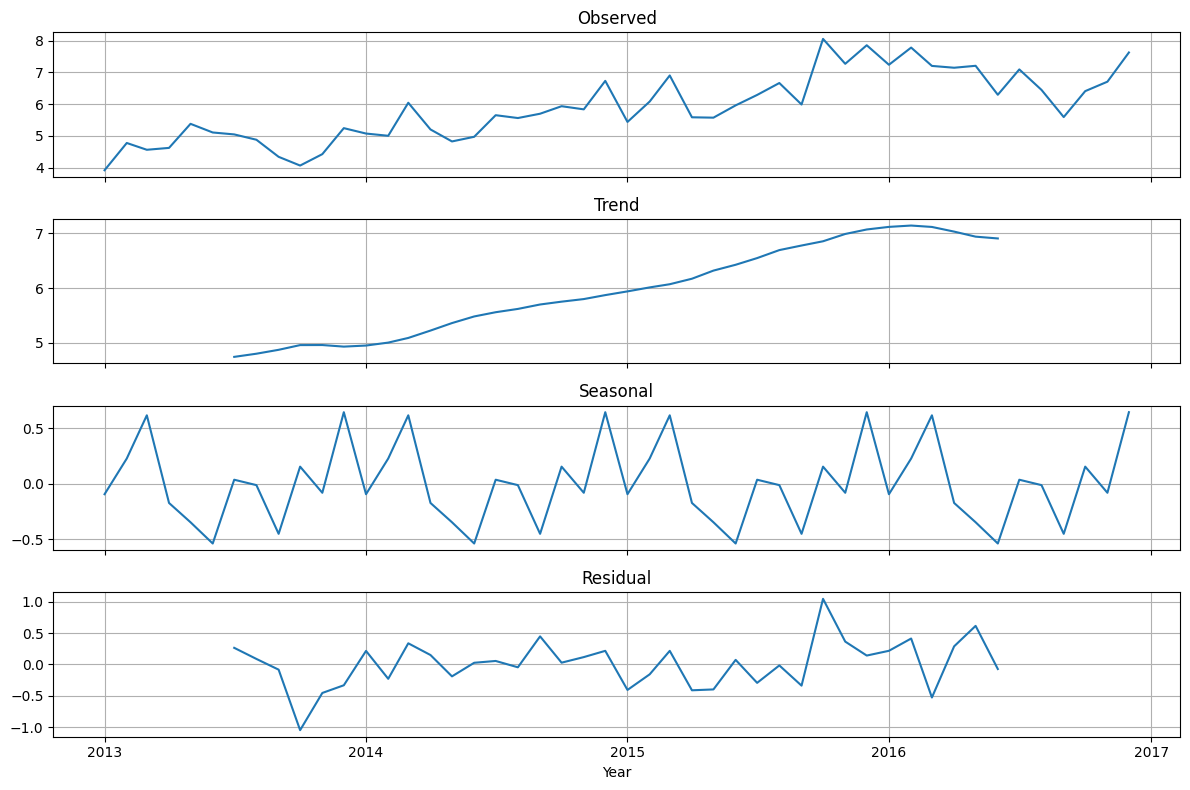

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'month' is datetime and set as index
automotive_monthly_sales['month'] = pd.to_datetime(automotive_monthly_sales['month'])
automotive_monthly_sales_indexed = automotive_monthly_sales.set_index('month')

# Decompose the time series
result = seasonal_decompose(automotive_monthly_sales_indexed['sales'], model='additive', period=12)

# Prepare the plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Date formatter and locator
date_fmt = mdates.DateFormatter('%Y')
year_locator = mdates.YearLocator()

# Plot all components
for i, component in enumerate(components):
    series = getattr(result, component)
    axes[i].plot(series.index, series.values)
    axes[i].set_title(titles[i])
    axes[i].xaxis.set_major_formatter(date_fmt)
    axes[i].xaxis.set_major_locator(year_locator)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(True)

axes[-1].set_xlabel('Year')

plt.tight_layout()
plt.show()


We can clearly see an upward trend in the first half of the year (trend panel) and a regular monthly seasonal pattern (third panel), with the residuals fluctuating around zero (last panel). This confirms the series = Trend + Seasonal + Residual

# Classical Model Building


## Identifying values of p, q, d

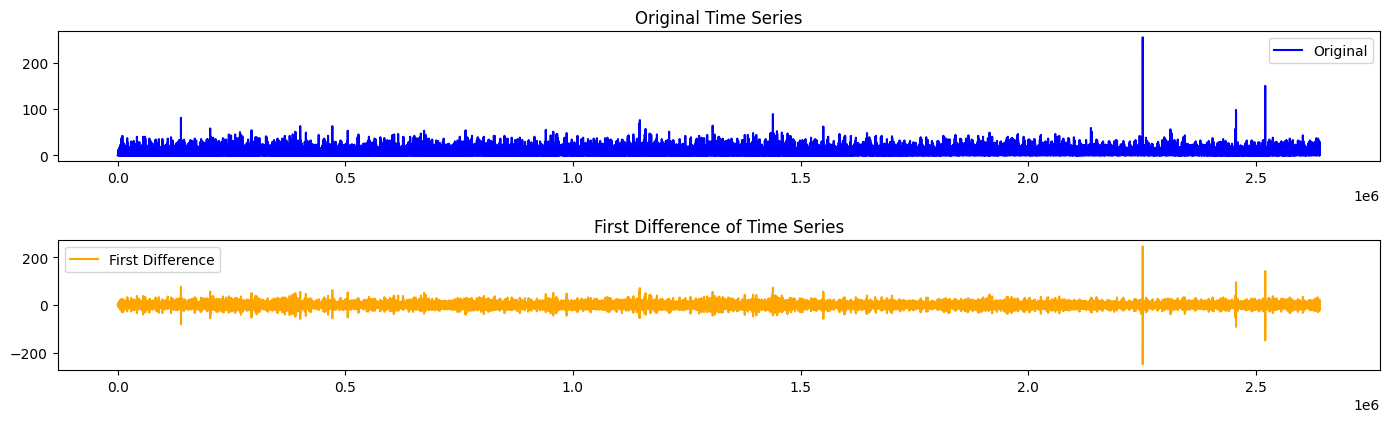

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot 1: Original series
plt.subplot(3, 1, 1)
plt.plot(automotive_train['sales'], label='Original', color='blue')
plt.title('Original Time Series')
plt.legend()

# Plot 2: First differenced series
plt.subplot(3, 1, 2)
plt.plot(automotive_train['sales'].diff(), label='First Difference', color='orange')
plt.title('First Difference of Time Series')
plt.legend()

plt.tight_layout()
plt.show()


If the original series has clear trend or seasonality, it's non-stationary.
If the differenced series looks randomly scattered around zero, it's probably stationary → set d=1.

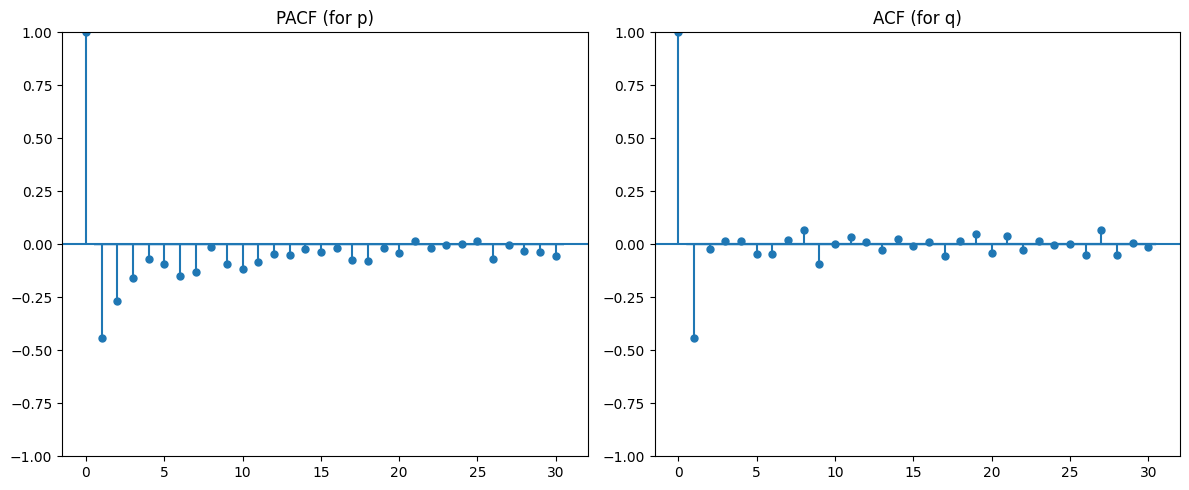

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# First difference (since d=1 assumed)
sales_diff = automotive_train['sales'].diff().dropna()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_pacf(sales_diff, ax=plt.gca(), lags=30)
plt.title('PACF (for p)')

plt.subplot(122)
plot_acf(sales_diff, ax=plt.gca(), lags=30)
plt.title('ACF (for q)')
plt.tight_layout()
plt.show()


We look for the last significant spike before the lags drop into the noise (confidence band).

From your PACF plot:
- Strong spike at lag 1.
- Possibly a small one at lag 2, but the rest are weak or within the bounds.

Therefore, p = 1 (maybe 2 at most)

From your ACF plot:
- Strong at lag 1.
- Then values drop off and stay within bounds.

Therefore, Suggested q = 1

Final ARIMA Order Suggestion:
(p, d, q) = (1, 1, 1)

## Using auto_arima to auto-tune (p,d,q)(P,D,Q,s)

In [ ]:
!pip install numpy==1.24.4 pmdarima==2.0.3


  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 20.8 MB/s eta 0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
  Attempting uninstall: pmdarima
    Fo

In [ ]:
# Ensure date is the index and sorted
automotive_train_ts = train[train['family'] == 'AUTOMOTIVE'].copy()
automotive_train_ts = automotive_train_ts[['date', 'sales']].copy()
automotive_train_ts.set_index('date', inplace=True)
automotive_train_ts = automotive_train_ts.sort_index()

# Resample to daily frequency if needed
automotive_train_ts = automotive_train_ts['sales'].resample('D').sum()

automotive_test_ts = test[test['family'] == 'AUTOMOTIVE'].copy()
automotive_test_ts = automotive_test_ts[['date', 'sales']].copy()
automotive_test_ts.set_index('date', inplace=True)
automotive_test_ts = automotive_test_ts.sort_index()
automotive_test_ts = automotive_test_ts['sales'].resample('D').sum()

In [ ]:
from pmdarima import auto_arima

# auto_arima needs a 1D series
stepwise_model = auto_arima(automotive_train_ts,
                             start_p=1, start_q=1,
                             max_p=2, max_q=2,
                             d=1,           # let it test for d
                             start_P=0, seasonal=True,
                             D=None,           # seasonal differencing
                             max_P=2, max_Q=2,
                             m=12,              # seasonality period (12 = monthly)
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

# Summary of the model
print(stepwise_model.summary())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=17818.262, Time=6.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18562.230, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=18369.646, Time=2.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17874.002, Time=6.74 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18560.238, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=1.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=17812.528, Time=10.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=17841.693, Time=9.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=17782.522, Time=13.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=17780.857, Time=9.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=17801.301, Time=7.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=18331.192, Time=4.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=17749.481, Time=20.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=17809.046, Time=4.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=17751.376, Time=20.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=17778.512, Time=10.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=18193.212, Time=9.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=17707.590, Time=22.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=17731.550, Time=11.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=17712.639, Time=27.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=17711.927, Time=10.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=17771.175, Time=14.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12]             : AIC=17706.060, Time=9.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12]             : AIC=17729.828, Time=3.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12]             : AIC=17707.629, Time=11.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=17710.368, Time=4.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=17770.546, Time=4.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12]             : AIC=17748.624, Time=9.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=17780.251, Time=4.03 sec

Best model:  ARIMA(2,1,2)(2,0,0)[12]          
Total fit time: 269.945 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1460
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood               -8846.030
Date:                             Thu, 07 Aug 2025   AIC                          17706.060
Time:                                     19:39:40   BIC                          17743.058
Sample:                                 01-01-2013   HQIC                         17719.862
                                      - 12-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

Best model:  ARIMA(2,1,2)(2,0,0)[12]

## Sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(automotive_train_ts,
                       order=(1,1,1),
                       seasonal_order=(2,0,0,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_results = sarima_model.fit()
print(sarima_results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1673
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 12)   Log Likelihood              -10123.487
Date:                             Mon, 11 Aug 2025   AIC                          20256.973
Time:                                     14:31:29   BIC                          20284.007
Sample:                                 01-01-2013   HQIC                         20266.997
                                      - 07-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1410      0.018      7.750      0.000       0.105       0.177
ma.L1         -1.0395      

In [ ]:
# Forecast
sarima_forecast = sarima_results.get_forecast(steps=15)
sarima_pred = sarima_forecast.predicted_mean

print(sarima_pred)

2017-08-01    395.806865
2017-08-02    397.721213
2017-08-03    414.189820
2017-08-04    419.344893
2017-08-05    453.799387
2017-08-06    450.327387
2017-08-07    456.629897
2017-08-08    418.464539
2017-08-09    401.812974
2017-08-10    401.205965
2017-08-11    410.860456
2017-08-12    445.631789
2017-08-13    434.833110
2017-08-14    428.446958
2017-08-15    395.009992
Freq: D, Name: predicted_mean, dtype: float64


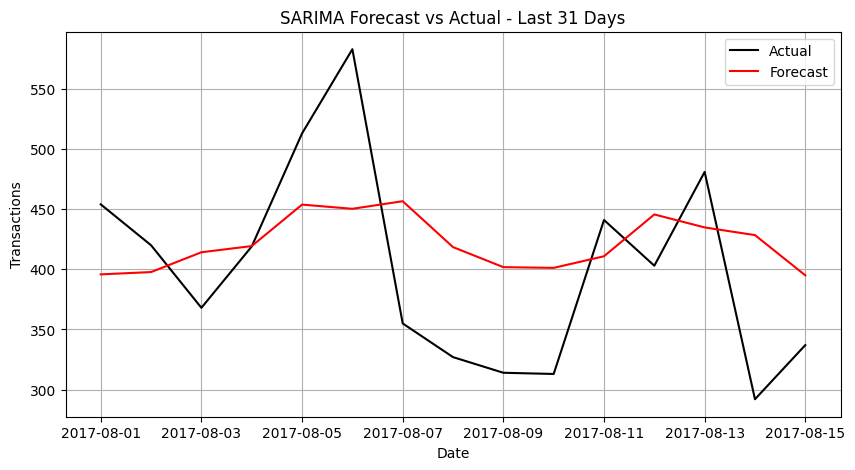

In [ ]:
import matplotlib.pyplot as plt

# Align predictions with actuals in case indexes differ
sarima_pred_aligned = sarima_pred.reindex(automotive_test_ts.index)

plt.figure(figsize=(10,5))
plt.plot(automotive_test_ts.index, automotive_test_ts, label='Actual', color='black')
plt.plot(sarima_pred_aligned.index, sarima_pred_aligned, label='Forecast', color='red')

plt.title('SARIMA Forecast vs Actual - Last 31 Days')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#evaluate model
# calculate mae, rmse

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(automotive_test_ts, sarima_pred_aligned)
rmse = np.sqrt(mean_squared_error(automotive_test_ts, sarima_pred_aligned))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 66.7592273457037
RMSE: 76.65903819635471


## Holt-Winters ETS model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 1. Fit the Holt-Winters model (you already did this)
hw_model = ExponentialSmoothing(
    automotive_train_ts,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

hw_fit = hw_model.fit()
print(hw_fit.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                 1673
Model:             ExponentialSmoothing   SSE                       24066857.853
Optimized:                         True   AIC                          16049.256
Trend:                         Additive   BIC                          16136.014
Seasonal:                      Additive   AICC                         16049.670
Seasonal Periods:                    12   Date:                 Mon, 11 Aug 2025
Box-Cox:                          False   Time:                         14:33:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0241156                alpha                 True
smoothing_trend          

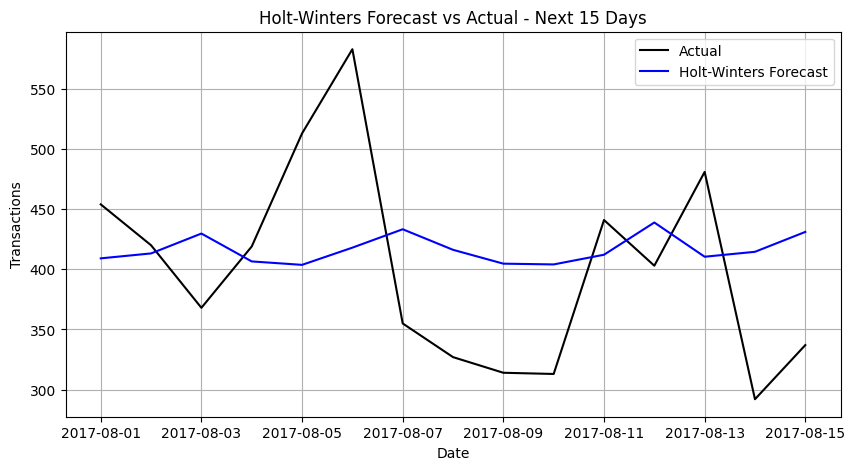

In [ ]:
# 2. Forecast the next 15 days
hw_forecast = hw_fit.forecast(steps=15)

# 3. Align forecast index to your test data dates
hw_forecast.index = automotive_test_ts.index

# 4. Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(automotive_test_ts.index, automotive_test_ts, label='Actual', color='black')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='blue')
plt.title('Holt-Winters Forecast vs Actual - Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#evaluate

mae = mean_absolute_error(automotive_test_ts, hw_forecast)
rmse = np.sqrt(mean_squared_error(automotive_test_ts, hw_forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 73.42798345075494
RMSE: 84.37299253921712


## Prophet model

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare training data for Prophet
# Prophet expects columns 'ds' (datetime) and 'y' (value)
train_df = automotive_train_ts.reset_index()
train_df.columns = ['ds', 'y']

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
model.fit(train_df)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxwewexz/b6f8pvix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxwewexz/nuo_wfub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71374', 'data', 'file=/tmp/tmpfxwewexz/b6f8pvix.json', 'init=/tmp/tmpfxwewexz/nuo_wfub.json', 'output', 'file=/tmp/tmpfxwewexz/prophet_model8oaan5n7/prophet_model-20250828134136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create dataframe to hold future dates for 15 days forecast
future = model.make_future_dataframe(periods=15)

# Forecast
forecast = model.predict(future)

# Extract forecasted values for the forecast period
forecast_15 = forecast.set_index('ds').loc[automotive_test_ts.index]



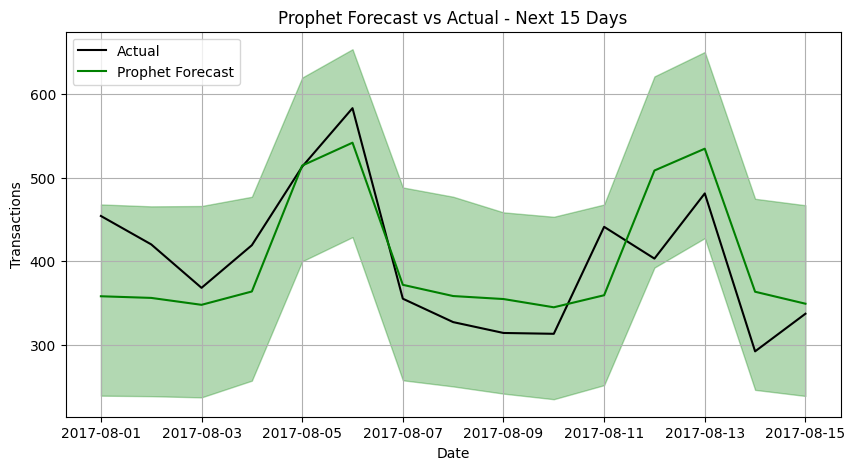

In [ ]:
# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(automotive_test_ts.index, automotive_test_ts.values, label='Actual', color='black')
plt.plot(forecast_15.index, forecast_15['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(forecast_15.index,
                 forecast_15['yhat_lower'],
                 forecast_15['yhat_upper'],
                 color='green', alpha=0.3)
plt.title('Prophet Forecast vs Actual - Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(automotive_test_ts, forecast_15['yhat'])
rmse = np.sqrt(mean_squared_error(automotive_test_ts, forecast_15['yhat']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 48.17536063717762
RMSE: 56.75988070843457


In [ ]:
forecast_15.head(2)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
date,,,,,,,,,,,,,,,,,,
2017-08-01,406.152885,238.959142,467.806130,406.152885,406.152885,-48.233972,-48.233972,-48.233972,-48.563106,-48.563106,-48.563106,0.329134,0.329134,0.329134,0.0,0.0,0.0,357.918914
2017-08-02,406.222420,238.359376,465.515706,406.222420,406.222420,-50.269120,-50.269120,-50.269120,-51.256322,-51.256322,-51.256322,0.987202,0.987202,0.987202,0.0,0.0,0.0,355.953299


Prophet is the most accurate model. So we will use that for predictions.

## Final Classical model

In [ ]:
families = train['family'].unique()
forecasts = {}

for fam in families:
    fam_df = train[train['family'] == fam].copy()
    # Prepare data for Prophet
    fam_df_prophet = fam_df[['date', 'transactions']].rename(columns={'date':'ds', 'transactions':'y'})

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(fam_df_prophet)

    future = model.make_future_dataframe(periods=15)
    forecast = model.predict(future)

    forecasts[fam] = forecast


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy68obq65/tv9kxrms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy68obq65/ha2a4bkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26904', 'data', 'file=/tmp/tmpy68obq65/tv9kxrms.json', 'init=/tmp/tmpy68obq65/ha2a4bkz.json', 'output', 'file=/tmp/tmpy68obq65/prophet_modelwxde7vyq/prophet_model-20250811143952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy6

# Machine Learning Model Building


## Feature Engineering

In [ ]:
train.shape

(3027618, 13)

In [ ]:
def feature_engineering_pipeline_fixed(train_df, test_df,
                                       lags=[1, 7, 14, 28, 365],
                                       windows=[7, 14, 28],
                                       fourier_settings=[(7, 3), (365, 3)]):

    def preprocess(df):
        # Map locale to weights
        locale_weights = {"national": 3, "regional": 2, "local": 1}
        df["locale_weight"] = df["locale"].map(locale_weights)

        # Aggregate per family-date (keep all columns we need)
        df_family = (
            df.groupby(["family", "date"], as_index=False)
              .agg({
                  "sales": "sum",
                  "onpromotion": "sum",
                  "locale_weight": "sum",
                  "holiday": lambda x: x.sum()/x.count(),
                  "workday": lambda x: x.sum()/x.count(),
                  "dcoilwtico": "first",
                  "transactions": "sum"
              })
              .rename(columns={"locale_weight": "holiday_weight"})
              .sort_values(["family", "date"])
        )

        df_family["dcoilwtico"] = df_family.groupby("family")["dcoilwtico"].ffill()

        def add_fourier_terms(df, period, order):
          """ Adds Fourier series terms for capturing smooth seasonal patterns.
          period: seasonal cycle length (e.g., 7 for weekly, 365 for yearly)
          order: number of sine/cosine pairs to include """
          t = np.arange(len(df))
          for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * t / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * t / period)
          return df

        # Calendar features
        df_family["day"] = df_family["date"].dt.day
        df_family["month"] = df_family["date"].dt.month
        df_family["year"] = df_family["date"].dt.year
        df_family["dayofweek"] = df_family["date"].dt.dayofweek
        df_family["is_weekend"] = df_family["dayofweek"].isin([5,6]).astype(int)

        # Lag features
        for lag in lags:
            df_family[f"lag_{lag}"] = df_family.groupby("family")["sales"].shift(lag)

        # Rolling stats
        for w in windows:
            df_family[f"roll_mean_{w}"] = df_family.groupby("family")["sales"].shift(1).rolling(w).mean()
            df_family[f"roll_std_{w}"] = df_family.groupby("family")["sales"].shift(1).rolling(w).std()
            df_family[f"roll_min_{w}"] = df_family.groupby("family")["sales"].shift(1).rolling(w).min()
            df_family[f"roll_max_{w}"] = df_family.groupby("family")["sales"].shift(1).rolling(w).max()

        # Fourier terms
        for period, order in fourier_settings:
            df_family = add_fourier_terms(df_family, period, order)

        return df_family

    # Process train/test
    train_features = preprocess(train_df)
    test_features = preprocess(test_df)

    return train_features, test_features

train_features, test_features = feature_engineering_pipeline_fixed(train, test)


/tmp/ipython-input-3109983059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["locale_weight"] = df["locale"].map(locale_weights)
/tmp/ipython-input-3109983059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["locale_weight"] = df["locale"].map(locale_weights)


In [ ]:
train_features.shape

(55077, 43)

In [ ]:
train_features.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55077 entries, 0 to 55076
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   family          55077 non-null  object        
 1   date            55077 non-null  datetime64[ns]
 2   sales           55077 non-null  float64       
 3   onpromotion     55077 non-null  int64         
 4   holiday_weight  55077 non-null  float64       
 5   holiday         55077 non-null  float64       
 6   workday         55077 non-null  float64       
 7   dcoilwtico      55044 non-null  float64       
 8   transactions    55077 non-null  float64       
 9   day             55077 non-null  int32         
 10  month           55077 non-null  int32         
 11  year            55077 non-null  int32         
 12  dayofweek       55077 non-null  int32         
 13  is_weekend      55077 non-null  int64         
 14  lag_1           55044 non-null  float64       
 15  la

In [ ]:
train_features.head()

,family,date,sales,onpromotion,holiday_weight,holiday,workday,dcoilwtico,transactions,day,...,sin_7_2,cos_7_2,sin_7_3,cos_7_3,sin_365_1,cos_365_1,sin_365_2,cos_365_2,sin_365_3,cos_365_3
0,AUTOMOTIVE,2013-01-01,0.0,0,0.0,1.0,1.0,NaN,770.0,1,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,AUTOMOTIVE,2013-01-02,255.0,0,0.0,0.0,1.0,93.14,93215.0,2,...,0.974928,-0.222521,0.433884,-0.900969,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667
2,AUTOMOTIVE,2013-01-03,161.0,0,0.0,0.0,1.0,92.97,78504.0,3,...,-0.433884,-0.900969,-0.781831,0.623490,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671
3,AUTOMOTIVE,2013-01-04,169.0,0,0.0,0.0,1.0,93.12,78494.0,4,...,-0.781831,0.623490,0.974928,-0.222521,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023
4,AUTOMOTIVE,2013-01-05,342.0,0,0.0,0.0,0.0,93.12,93573.0,5,...,0.781831,0.623490,-0.974928,-0.222521,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740


## Comparing Regression Models

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer


def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def model_pipeline(train_features, test_features, target_col="sales"):
    # Filter only automotive family
    train_auto = train_features[train_features["family"] == "AUTOMOTIVE"].copy()
    test_auto = test_features[test_features["family"] == "AUTOMOTIVE"].copy()

    # Drop columns not useful for modeling
    drop_cols = ["family", "date", "series_id"]
    X_train = train_auto.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_train = train_auto[target_col]
    X_test = test_auto.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_test = test_auto[target_col] if target_col in test_auto.columns else None

    # Impute missing values for the entire feature sets
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)


    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.001),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "CatBoost": CatBoostRegressor(iterations=200, learning_rate=0.1, verbose=0, random_state=42)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        if y_test is not None:
            rmse, mae, r2 = evaluate_model(y_test, preds)
            results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2})
        else:
            results.append({"Model": name, "RMSE": None, "MAE": None, "R²": None})

    results_df = pd.DataFrame(results)
    return results_df

# ---- USAGE ----
# Assume you already ran: train_features, test_features = feature_engineering_pipeline(train, test)
results_df = model_pipeline(train_features, test_features)
print(results_df.sort_values("RMSE"))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+06, tolerance: 2.855e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7258
[LightGBM] [Info] Number of data points in the train set: 1669, number of used features: 39
[LightGBM] [Info] Start training from score 335.756741


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


               Model       RMSE        MAE        R²
4      Random Forest  72.844360  54.796667  0.180581
3      Decision Tree  75.259969  57.893886  0.125334
7           CatBoost  79.135836  66.973999  0.032924
5            XGBoost  80.823161  64.501440 -0.008755
1   Ridge Regression  90.149013  70.820681 -0.254978
2   Lasso Regression  90.261885  70.901830 -0.258122
0  Linear Regression  90.285185  70.919115 -0.258772
6           LightGBM  98.629626  79.444741 -0.502204


Might need to create better features for this to show improvement.

## LSTM - Deep Learning

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -----------------------------
# 1. Prepare the Data
# -----------------------------
# Filter for automotive family
df_auto = train_features[train_features["family"] == "AUTOMOTIVE"].copy()

# Define target and features
y = df_auto["sales"]
X = df_auto.drop(columns=["sales", "family", "date"])  # keep family out of X

# Impute missing values in X
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)

# Scale features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_imputed)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)) # Corrected: Use .values or .to_numpy()

# -----------------------------
# 2. Create sequences for LSTM
# -----------------------------
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# -----------------------------
# 3. Train-Test Split
# -----------------------------
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# -----------------------------
# 4. Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(TIME_STEPS, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# -----------------------------
# 5. Train Model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)

# -----------------------------
# 6. Predictions
# -----------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# -----------------------------
# 7. Evaluation Metrics
# -----------------------------
mae = mean_absolute_error(y_test_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
r2 = r2_score(y_test_inv, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,945 (105.25 KB)

 Trainable params: 26,945 (105.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7315 - val_loss: 1.8678
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4818 - val_loss: 1.7786
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4039 - val_loss: 1.7281
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3681 - val_loss: 1.6695
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3163 - val_loss: 1.6166
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3072 - val_loss: 1.5936
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3096 - val_loss: 1.5822
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3069 - val_loss: 1.5359
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2542 - val_loss: 1.5573
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2684 - val_loss: 1.5347
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2546 - val_loss: 1.5140
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2

Deep learning models dont perform well with less quantity of data.

# Ensembling
Prophet (Best Time series model) + Random Forest (Best ML Model)

In [ ]:
# --- Train Random Forest on train set ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

def random_forest_forecast(train_features, test_features, target_col="sales"):
    train_auto = train_features[train_features["family"] == "AUTOMOTIVE"].copy()
    test_auto = test_features[test_features["family"] == "AUTOMOTIVE"].copy()

    drop_cols = ["family", "date", "series_id"]
    X_train = train_auto.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_train = train_auto[target_col]
    X_test = test_auto.drop(columns=[target_col] + drop_cols, errors='ignore')
    dates = test_auto["date"].reset_index(drop=True)  # keep date info

    # Imputation
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    rf_forecast = pd.DataFrame({"date": dates, "rf_pred": preds}).set_index("date")
    return rf_forecast

# Get RF predictions
rf_forecast = random_forest_forecast(train_features, test_features)

# Align with Prophet forecast (make sure both have date as index)
prophet_forecast = forecast_15[["yhat"]].copy()

# Merge on date
ensemble = rf_forecast.join(prophet_forecast, how="inner")

# Average predictions
ensemble["avg_pred"] = ensemble[["rf_pred", "yhat"]].mean(axis=1)

print(ensemble.head(15))

            rf_pred        yhat    avg_pred
date                                       
2017-08-01   350.84  357.918914  354.379457
2017-08-02   366.73  355.953299  361.341650
2017-08-03   312.08  347.678018  329.879009
2017-08-04   377.64  363.633486  370.636743
2017-08-05   406.15  514.295512  460.222756
2017-08-06   393.13  541.679063  467.404531
2017-08-07   335.80  371.614589  353.707294
2017-08-08   319.00  358.178682  338.589341
2017-08-09   308.81  354.595961  331.702980
2017-08-10   316.23  344.722195  330.476097
2017-08-11   385.52  359.145915  372.332957
2017-08-12   454.05  508.386495  481.218247
2017-08-13   400.68  534.496717  467.588359
2017-08-14   317.30  363.338109  340.319054
2017-08-15   313.25  349.010845  331.130423


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(automotive_test_ts, ensemble["avg_pred"])
rmse = np.sqrt(mean_squared_error(automotive_test_ts, ensemble["avg_pred"]))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 45.04550272503972
RMSE: 56.23885045338095


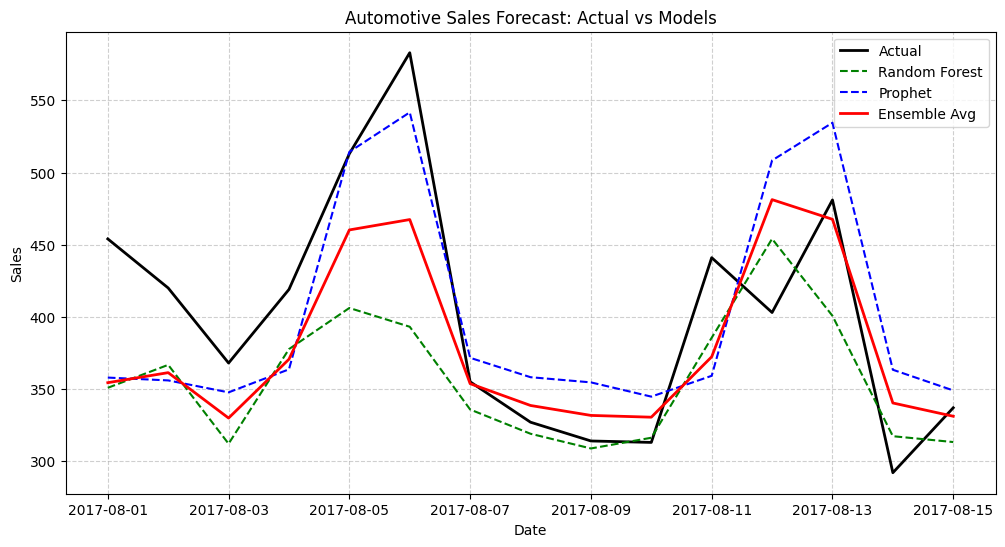

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Actual values
plt.plot(automotive_test_ts.index, automotive_test_ts.values,
         label="Actual", color="black", linewidth=2)

# Random Forest
plt.plot(rf_forecast.index, rf_forecast["rf_pred"],
         label="Random Forest", color="green", linestyle="--")

# Prophet
plt.plot(forecast_15.index, forecast_15["yhat"],
         label="Prophet", color="blue", linestyle="--")

# Ensemble average
plt.plot(ensemble.index, ensemble["avg_pred"],
         label="Ensemble Avg", color="red", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Automotive Sales Forecast: Actual vs Models")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Ensembling leads to better results!

# Residual Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# --- Residuals ---
residuals = automotive_test_ts.values - ensemble["avg_pred"].values

# --- Residual mean ---
residual_mean = np.mean(residuals)
print("Residual mean:", residual_mean)



Residual mean: 21.938073368270047


<Figure size 800x500 with 0 Axes>

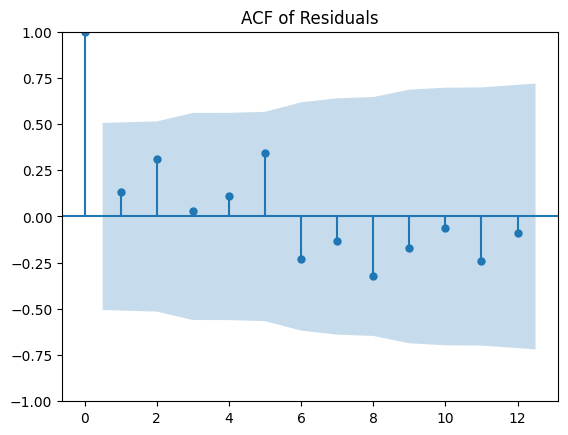

In [ ]:
# --- Residual ACF at lag 1 and 12 ---
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8,5))
plot_acf(residuals, lags=12, alpha=0.05)  # 40 lags (you can reduce if needed)
plt.title("ACF of Residuals")
plt.show()





All ACF spikes (except lag 0 = 1 by definition) lie inside the confidence band, so none are statistically significant. That suggests the residuals are approximately white noise

In [ ]:
# --- Ljung-Box test ---
lb_test = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("Ljung-Box test (lag 12):\n", lb_test)

Ljung-Box test (lag 12):
       lb_stat  lb_pvalue
12  17.121863    0.14507


Null hypothesis (H₀): Residuals are independently distributed (no autocorrelation up to lag 12).

Alternative hypothesis (H₁): Residuals show significant autocorrelation.

p-value = 0.145 → This is greater than common significance levels (0.05 or 0.01).

That means you do not reject the null hypothesis.

In plain terms: there is no strong evidence of autocorrelation in residuals up to lag 12.

The Ljung–Box test confirms that those spikes aren’t statistically significant overall.

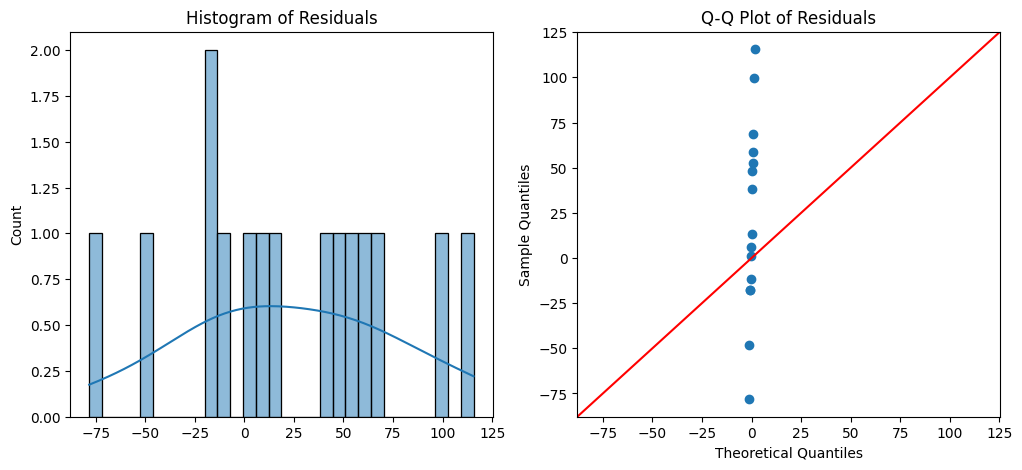

In [ ]:
# --- Histogram & Q-Q Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Histogram of Residuals")
sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")
plt.show()


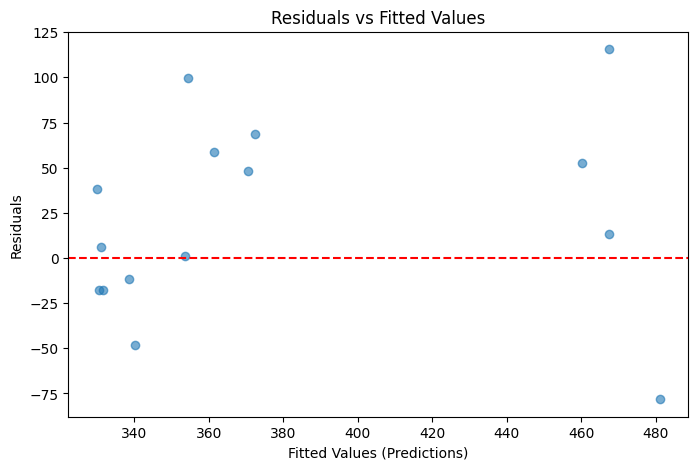

In [ ]:
# --- Residuals vs Fitted values ---
plt.figure(figsize=(8,5))
plt.scatter(ensemble["avg_pred"], residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

As fitted values move right (≈330 → 480), the spread of residuals grows (a “fan/megaphone” shape).

There are a couple of large residuals at high fitted values (≈+120 and ≈−75), reinforcing the non-constant variance.

The residuals are roughly centered around 0 (no obvious systematic curve), so the main issue is non-constant variance, i.e., heteroscedasticity that increases with the predicted level.

In [ ]:
# --- Error metrics by weekday vs weekend ---
residuals_df["is_weekend"] = residuals_df["weekday"] >= 5

weekday_residuals = residuals_df[~residuals_df["is_weekend"]]["residuals"]
weekend_residuals = residuals_df[residuals_df["is_weekend"]]["residuals"]

weekday_rmse = np.sqrt(mean_squared_error(np.zeros_like(weekday_residuals), weekday_residuals))
weekend_rmse = np.sqrt(mean_squared_error(np.zeros_like(weekend_residuals), weekend_residuals))

print("Weekday RMSE:", weekday_rmse)
print("Weekend RMSE:", weekend_rmse)

Weekday RMSE: 47.669704836915884
Weekend RMSE: 74.90947228678877


The model predictions seem to be more accurate on weekdays compared to weekends.

## **Summary**

## What’s working

* **No leftover time patterns.** ACF + Ljung–Box say residuals look like white noise → trend/seasonality/lag effects are mostly handled. Good.

## What’s not working (and why it matters)

* **Systematic under-prediction.** Mean residual ≈ **+22** → on average are **22 units too low**. If we ship this, we’ll repeatedly under-stock.
* **Errors grow when sales are high.** The “fan shape” in residuals vs fitted = **heteroscedasticity**. Misses are small on low days and big on high days. If we use one-size-fits-all intervals, they’ll be too narrow on big sales days.
* **Weekends are tougher.** Weekend RMSE >> weekday RMSE → weekends need special treatment.

## Quick, practical fixes (implementation-first)

### 1) Remove the bias (fastest win)

* **Post-hoc calibration:** compute `bias = mean(residuals)` on a validation slice and **add it to all future predictions**.

  * Implementation: `y_pred_cal = y_pred + bias`.


* **Better:** **stacking with an intercept.** Instead of 50/50 Prophet+RF, fit a tiny linear model on a recent validation window:

  * Inputs: `[prophet_pred, rf_pred, 1]`
  * Learn weights and an intercept → this usually kills systematic bias.

### 2) Tame the “fan” (errors grow with level)

Pick **one** of these (they’re listed from easiest to most robust):

* **Log target** (simple, strong baseline):

  1. Train Prophet and RF on `log1p(sales)`.
  2. Predict `log_sales_hat`; back-transform with bias correction: `sales_hat = exp(log_sales_hat + 0.5 * residual_var)`
  3. Your intervals will naturally widen on big days.

* **Prophet multiplicative mode:** set `seasonality_mode='multiplicative'` so weekly/holiday effects scale with level.
* **Distribution that links mean & variance:** try **Tweedie/Poisson/NegBin** in a GBM (e.g., LightGBM/Tweedie). Great when variance grows with the mean.
* **Quantile models** (no distribution assumptions): train a **quantile regressor** (e.g., LightGBM/XGBoost) for P10/P50/P90 so high-level days get wider intervals automatically.

### 3) Fix weekends

* Add `is_weekend` and interactions: `is_weekend × month`, `is_weekend × weather`, etc.
* Option A (simple): **separate models** for weekday vs weekend.
* Option B (one model): include `is_weekend` and let RF/GBM learn different behavior.

### 4) Make the ensemble smarter

* Use **time-series cross-validation** (rolling windows) to learn **weights** for Prophet vs RF (they won’t be 50/50).
* Add a third learner to **model the residuals** of the stack (small Gradient Boosting on errors).

### 5) Outliers → events

* Investigate the \~+120 and \~−75 misses. If they’re promos, stock-outs, holidays, local events—**add flags** so the model knows those days are special next time.

## What this means for your next 31 days

* With the bias fix + heteroscedasticity fix, your point forecast will stop chronically under-estimating, and your **intervals will finally be wide enough on big days** (especially weekends).
* Expect the **largest accuracy gains on weekends and high-volume days**.

## Monitoring after deployment

* Track **bias** (mean residual) weekly.
* Track **interval coverage** overall and for top-decile sales days; aim for \~90% coverage for a P5–P95 band.
* Track **weekday vs weekend** metrics; if weekend drifts, retrain the weekend component more often.
